In [1]:
# === train_model_gridsearch.py ===
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
print("✅ Preprocessing complete.")

✅ Preprocessing complete.


In [2]:
# === Step 0: Load dataset ===
df = pd.read_csv("C:/Users/satth/Desktop/C2/clustered_output_final.csv")
print("✅ Preprocessing complete.")

✅ Preprocessing complete.


In [3]:
# === Step 1: Map clusters to learning strategies and clean ===
cluster_to_strategy = {
    0: "Plan A",
    1: "Plan B",
    2: "Plan C",
    3: "Plan D"
}

df["Learning_Strategies"] = df["Cluster_k4"].map(cluster_to_strategy)

# Drop unused cluster columns to avoid confusion
df = df.drop(columns=["Cluster_k5", "Cluster_k6"])

# === Step 2: Split 80/20 ===
from sklearn.model_selection import train_test_split

train_df, holdout_df = train_test_split(df, test_size=0.2, random_state=42)

# Save unlabeled input and true labels separately
holdout_df.drop(columns=["Learning_Strategies"]).reset_index(drop=True).to_csv("raw_20_percent_unlabeled.csv", index=False)
holdout_df[["Learning_Strategies"]].reset_index(drop=True).to_csv("true_labels.csv", index=False)

print("📤 Saved raw 20% (unlabeled) as 'raw_20_percent_unlabeled.csv'")
print("📤 Saved true labels for evaluation as 'true_labels.csv'")

📤 Saved raw 20% (unlabeled) as 'raw_20_percent_unlabeled.csv'
📤 Saved true labels for evaluation as 'true_labels.csv'


In [4]:
# === Step 3: Encode features ===
categorical_cols = ['Motivation_Type', 'Learning_Style', 'Social_Interaction_Style']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    holdout_df[col] = le.transform(holdout_df[col])
    label_encoders[col] = le
    joblib.dump(le, f"encoder_{col}.joblib")

# Encode target
target_le = LabelEncoder()
train_df['Learning_Strategies'] = target_le.fit_transform(train_df['Learning_Strategies'])
holdout_df['Learning_Strategies'] = target_le.transform(holdout_df['Learning_Strategies'])
joblib.dump(target_le, "encoder_target.joblib")
print("✅ Preprocessing complete.")

✅ Preprocessing complete.


In [5]:
# === Step 4: Split features and labels ===
features = [
    'Age', 'Attention_Span', 'Emotional_Regulation',
    'Motivation_Type', 'Parental_Involvement',
    'Learning_Style', 'Social_Interaction_Style'
]

X_train = train_df[features]
y_train = train_df['Learning_Strategies']

X_test = holdout_df[features]
y_test = holdout_df['Learning_Strategies']
print("✅ Preprocessing complete.")

✅ Preprocessing complete.


In [6]:
# === Step 5: Define parameter grid for tuning ===
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}
print("✅ Preprocessing complete.")

✅ Preprocessing complete.


In [7]:
# === Step 6: Grid Search with Cross-Validation ===
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"✅ Best Parameters: {grid_search.best_params_}")
print(f"✅ Best Cross-Validation Accuracy (5 fold, with Hyper parameter tuning) : {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
✅ Best Parameters: {'class_weight': None, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
✅ Best Cross-Validation Accuracy (5 fold, with Hyper parameter tuning) : 0.9984


In [8]:
# === Step 7: Save best model ===
best_model = grid_search.best_estimator_
joblib.dump(best_model, "rf_model_gridsearch.joblib")
print("✅ Best model saved as 'rf_model_gridsearch.joblib'")

✅ Best model saved as 'rf_model_gridsearch.joblib'


In [9]:
# === Step 8: Evaluate on holdout ===
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"📊 Holdout Test Accuracy: {acc:.4f}")
print("📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))   

📊 Holdout Test Accuracy: 0.9938
📄 Classification Report:
              precision    recall  f1-score   support

      Plan A       1.00      1.00      1.00        49
      Plan B       1.00      1.00      1.00        29
      Plan C       1.00      0.98      0.99        42
      Plan D       0.98      1.00      0.99        40

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



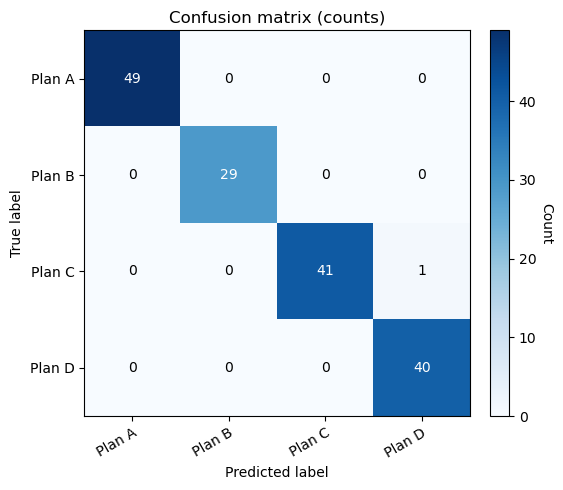

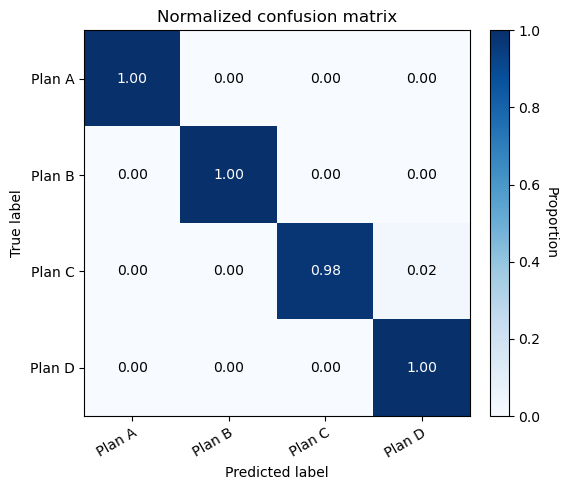

In [10]:
# === Robust Confusion Matrix Builder (handles string/numeric labels & variants) ===
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.metrics import confusion_matrix, classification_report

# Expect y_test and y_pred to be defined earlier in your notebook/script
# Convert to Series (no copies if already Series)
y_true = pd.Series(y_test)
y_hat  = pd.Series(y_pred)

# 2) Try to decode numeric labels using saved encoder if present
def maybe_decode(series):
    # If elements are integers, try to inverse_transform using encoder_target.joblib
    if pd.api.types.is_integer_dtype(series):
        enc_path = "encoder_target.joblib"
        if os.path.exists(enc_path):
            import joblib
            enc = joblib.load(enc_path)
            try:
                return pd.Series(enc.inverse_transform(series.values))
            except Exception:
                # fallback: keep as integers
                return series
    return series

y_true = maybe_decode(y_true)
y_hat  = maybe_decode(y_hat)

# 3) Standardize common string variants
def to_plan_label(s):
    if not isinstance(s, str):
        return s  # e.g., still integer label
    t = s.strip()
    # Normalize common variants
    mapping = {
        "A": "Plan A", "B": "Plan B", "C": "Plan C", "D": "Plan D",
        "PLAN A": "Plan A", "PLAN B": "Plan B", "PLAN C": "Plan C", "PLAN D": "Plan D",
        "PlanA": "Plan A", "PlanB": "Plan B", "PlanC": "Plan C", "PlanD": "Plan D"
    }
    return mapping.get(t, t)

if y_true.dtype == "object":
    y_true = y_true.astype(str).map(to_plan_label)
if y_hat.dtype == "object":
    y_hat  = y_hat.astype(str).map(to_plan_label)

# 4) Decide internal labels & display names
PLAN_ORDER = ["Plan A", "Plan B", "Plan C", "Plan D"]

if pd.api.types.is_integer_dtype(y_true) or pd.api.types.is_integer_dtype(y_hat):
    # numeric classes; infer sorted unique
    internal_labels = sorted(pd.unique(pd.concat([y_true, y_hat])))
    # Build display names if these are exactly [0,1,2,3]
    display_names = []
    num_to_name = {0:"Plan A", 1:"Plan B", 2:"Plan C", 3:"Plan D"}
    for c in internal_labels:
        display_names.append(num_to_name.get(int(c), str(c)))
else:
    # string classes; use PLAN_ORDER if present, else use observed
    observed = sorted(pd.unique(pd.concat([y_true, y_hat])))
    if all(lbl in observed for lbl in PLAN_ORDER):
        internal_labels = PLAN_ORDER
    else:
        internal_labels = observed
    display_names = internal_labels

# 5) Safety check: ensure at least one specified label exists in y_true
if len(set(internal_labels).intersection(set(pd.unique(y_true)))) == 0:
    raise ValueError(
        f"No overlap between specified labels {internal_labels} and y_true uniques {pd.unique(y_true)}.\n"
        "Inspect your labels for unexpected whitespace/casing or run the diagnostic print below."
    )

# 6) Build confusion matrix
cm = confusion_matrix(y_true, y_hat, labels=internal_labels)

# 7) Save numeric matrix (counts)
cm_counts = pd.DataFrame(
    cm,
    index=[f"True {n}" for n in display_names],
    columns=[f"Pred {n}" for n in display_names]
)
cm_counts.to_csv("confusion_matrix_strategies.csv", index=True)

# 8) Normalized matrix (% by true row)
cm_norm = (cm / cm.sum(axis=1, keepdims=True)) * 100.0
cm_norm_df = pd.DataFrame(
    np.round(cm_norm, 2),
    index=[f"True {n}" for n in display_names],
    columns=[f"Pred {n}" for n in display_names]
)
cm_norm_df.to_csv("confusion_matrix_strategies_normalized.csv", index=True)

# 9) Plot counts matrix (Blues colormap + colorbar)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues", norm=Normalize(vmin=0, vmax=cm.max()))
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Count", rotation=270, labelpad=12)

ax.set_xticks(np.arange(len(display_names)))
ax.set_yticks(np.arange(len(display_names)))
ax.set_xticklabels(display_names)
ax.set_yticklabels(display_names)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

threshold = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > threshold else "black",
            fontsize=10
        )

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion matrix (counts)")
plt.tight_layout()
plt.savefig("confusion_matrix_strategies.png", dpi=300)
plt.show()

# 10) Plot normalized matrix 
cm_norm01 = cm_norm / 100.0  # convert % → 0–1 for display
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_norm01, cmap="Blues", norm=Normalize(vmin=0.0, vmax=1.0))
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Proportion", rotation=270, labelpad=12)

ax.set_xticks(np.arange(len(display_names)))
ax.set_yticks(np.arange(len(display_names)))
ax.set_xticklabels(display_names)
ax.set_yticklabels(display_names)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

threshold = 0.5
for i in range(cm_norm01.shape[0]):
    for j in range(cm_norm01.shape[1]):
        ax.text(
            j, i, f"{cm_norm01[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm_norm01[i, j] > threshold else "black",
            fontsize=10
        )

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Normalized confusion matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_strategies_normalized.png", dpi=300)
plt.show()

# 11) Diagnostics (optional): uncomment to see what your labels look like
# print("y_true uniques:", sorted(pd.unique(y_true)))
# print("y_pred uniques:", sorted(pd.unique(y_hat)))
# print("Internal labels used:", internal_labels)
# print("Display names:", display_names)


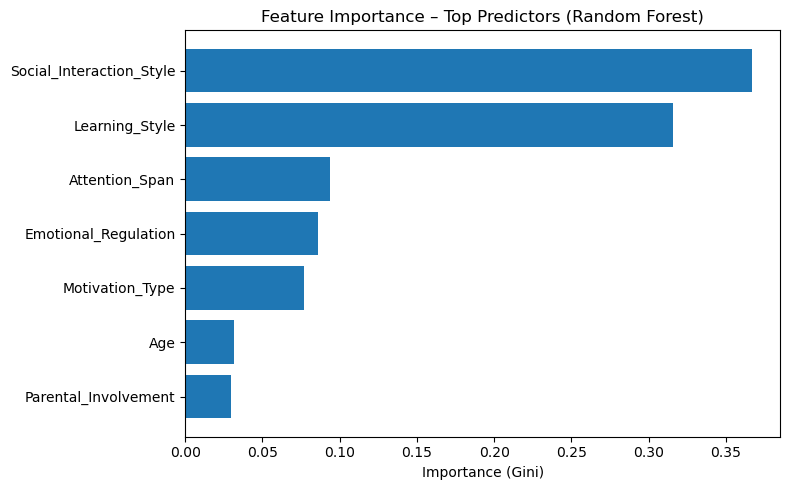

Saved: feature_importance_top.png
Saved: feature_importances_top.csv
Saved: feature_importances_full.csv


In [11]:
# === 4.4 Feature Importance Bar Chart (Top Predictors) ===
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# -------- Paths & fallback feature list (matches your training script) --------
BASE = os.getcwd()
PATH_MODEL = os.path.join(BASE, "rf_model_gridsearch.joblib")
PATH_XTEST = os.path.join(BASE, "raw_20_percent_unlabeled.csv")  # optional, for column names

FALLBACK_FEATURES = [
    "Age",
    "Attention_Span",
    "Emotional_Regulation",
    "Motivation_Type",
    "Parental_Involvement",
    "Learning_Style",
    "Social_Interaction_Style",
]

# -------- Load model --------
rf_model = joblib.load(PATH_MODEL)

# If you saved a Pipeline, get the RF estimator from it; else assume it's a RandomForestClassifier
rf_estimator = rf_model
try:
    # common names: 'model', 'clf', 'classifier'
    for key in ["model", "clf", "classifier"]:
        if hasattr(rf_model, key):
            rf_estimator = getattr(rf_model, key)
            break
except Exception:
    pass

# -------- Derive feature names robustly --------
feature_names = None

# 1) If it's a pipeline with a preprocessor that exposes names
try:
    if hasattr(rf_model, "get_feature_names_out"):
        feature_names = list(rf_model.get_feature_names_out())
    elif hasattr(rf_model, "named_steps"):
        # Try a preprocessor step (ColumnTransformer / OneHotEncoder)
        for step_name, step in rf_model.named_steps.items():
            if hasattr(step, "get_feature_names_out"):
                feature_names = list(step.get_feature_names_out())
                break
except Exception:
    feature_names = None

# 2) If X_test exists in memory, use its columns
if feature_names is None:
    if "X_test" in globals():
        try:
            feature_names = list(X_test.columns)
        except Exception:
            pass

# 3) If file exists, use its columns
if feature_names is None and os.path.exists(PATH_XTEST):
    try:
        tmpX = pd.read_csv(PATH_XTEST)
        feature_names = list(tmpX.columns)
    except Exception:
        pass

# 4) Fallback to manual list
if feature_names is None:
    feature_names = FALLBACK_FEATURES

# -------- Get feature importances --------
if hasattr(rf_estimator, "feature_importances_"):
    importances = np.array(rf_estimator.feature_importances_)
else:
    # If rf_model is a Pipeline, final step likely has it
    if hasattr(rf_model, "named_steps"):
        last_step_name = list(rf_model.named_steps.keys())[-1]
        last_step = rf_model.named_steps[last_step_name]
        importances = np.array(last_step.feature_importances_)
    else:
        raise AttributeError("Could not find feature_importances_ on the model/estimator.")

# Align lengths (in case of mismatch)
if len(importances) != len(feature_names):
    # truncate/pad cautiously
    n = min(len(importances), len(feature_names))
    importances = importances[:n]
    feature_names = feature_names[:n]

# -------- Build sorted table & save --------
fi_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
fi_df = fi_df.sort_values("Importance", ascending=False).reset_index(drop=True)

# Choose how many to show
TOP_K = min(10, len(fi_df))
fi_top = fi_df.head(TOP_K)

fi_df.to_csv("feature_importances_full.csv", index=False)
fi_top.to_csv("feature_importances_top.csv", index=False)

# -------- Plot horizontal bar chart (top predictors) --------
plt.figure(figsize=(8, 5))
plt.barh(fi_top["Feature"][::-1], fi_top["Importance"][::-1])  # reversed for highest on top
plt.xlabel("Importance (Gini)")
plt.title("Feature Importance – Top Predictors (Random Forest)")
plt.tight_layout()
plt.savefig("feature_importance_top.png", dpi=300)
plt.show()

print("Saved: feature_importance_top.png")
print("Saved: feature_importances_top.csv")
print("Saved: feature_importances_full.csv")
